In [ ]:
# !pip install matplotlib tqdm numpy

In [ ]:
import argparse
from pathlib import Path
import multiprocessing
from time import time
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tqdm import tqdm
from multiprocessor.scheduler import MultiprocessorSchedulerType
from multiprocessor.partitioner import FirstFit, NextFit, BestFit, WorstFit

# self-written modules
from utils.metrics import MultiprocessorFeasibility, calculate_success_rate
from utils.parse import parse_task_file
from utils.plotters import plot_feasibility_ratio
from multiprocessor.feasibility.review import review_task_sets_in_parallel_multi

import numpy as np


In [ ]:
# calculate feasibility ratio by parameter
def calculate_feasibility_ratio(schedule_stats):
    feasible = schedule_stats.get(MultiprocessorFeasibility.FEASIBLE_SHORTCUT, 0) + \
               schedule_stats.get(MultiprocessorFeasibility.FEASIBLE_SIMULATION, 0)
    total = feasible + schedule_stats.get(MultiprocessorFeasibility.NOT_SCHEDULABLE_BY_A_SHORTCUT, 0) + \
            schedule_stats.get(MultiprocessorFeasibility.NOT_SCHEDULABLE_BY_A_SIMULATION, 0)
    if total == 0:
        return 0
    return feasible / total * 1.0

In [ ]:
# process task sets for Plot 1 and 2 (by number of tasks)

from utils.plotters import plot_primary_categories


def average_execution_time_by_workers(config, folder_name):
    """
    Process task sets organized by number of tasks (like in 4-tasks, 10-tasks).
    """
    # subfolders = sorted([f for f in Path(folder_name).iterdir() if f.is_dir()], key=lambda x: int(x.name))
    # print(subfolders)
    execution_times = []

    workers = config["number_of_workers"]

    for worker_quantity in workers:
        start_time = time()

        print(f"Executing with: {worker_quantity} workers.")
        print(f"Evaluating algorithm: {config['alg'].name}")
        
        times = []
        
        for i in range(10):
            print(f"Evaluating test {i + 1} of {10}")
            schedule_stats = review_task_sets_in_parallel_multi(
                algorithm=config["alg"],
                folder_name=folder_name,
                num_processors=config["processors"],
                #num_clusters=config["clusters"],
                heuristic=config["heuristic"],
                number_of_workers=worker_quantity)
                # success_rate = calculate_success_rate(schedule_stats) #TODO execution time
                # execution_times[num_tasks] = success_rate
            end_time = time() - start_time
            times.append(end_time)
        average_time = np.mean(times)
        print(average_time)

        execution_times.append(
            {
                "workers": worker_quantity,
                "time": average_time
            }
        )

    return execution_times

In [ ]:
def plot_average_execution_time(data):
    for result in data:
        print(f"Time taken for {result['workers']} workers: {result['time']}")

    workers = [result["workers"] for result in data]
    times = [result["time"] for result in data]

    plt.figure(figsize=(12, 6))
    plt.bar(workers, times, color='teal', width=0.6)
    plt.xlabel('Number of Workers')
    plt.ylabel('Time Taken (seconds)')
    plt.title('Time Taken vs Number of Workers')
    plt.xticks(workers)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [ ]:
def get_workers_range(from_val, to_val):
    return list(range(from_val, to_val + 1))

In [ ]:
config_to_evaluate = {
        "alg": MultiprocessorSchedulerType.PARTITIONED_EDF,
        "heuristic": BestFit(decreasing_utilisation=True, verbose=False),
        "processors": 8,
        "number_of_workers": get_workers_range(1, 32)
    }
# python3 main.py tasksets-multiprocessor 8 partitioned -H bf -s du

results = average_execution_time_by_workers(config=config_to_evaluate, folder_name="tasksets-multiprocessor/")

In [ ]:
plot_average_execution_time(results)

Total files considered: 1000


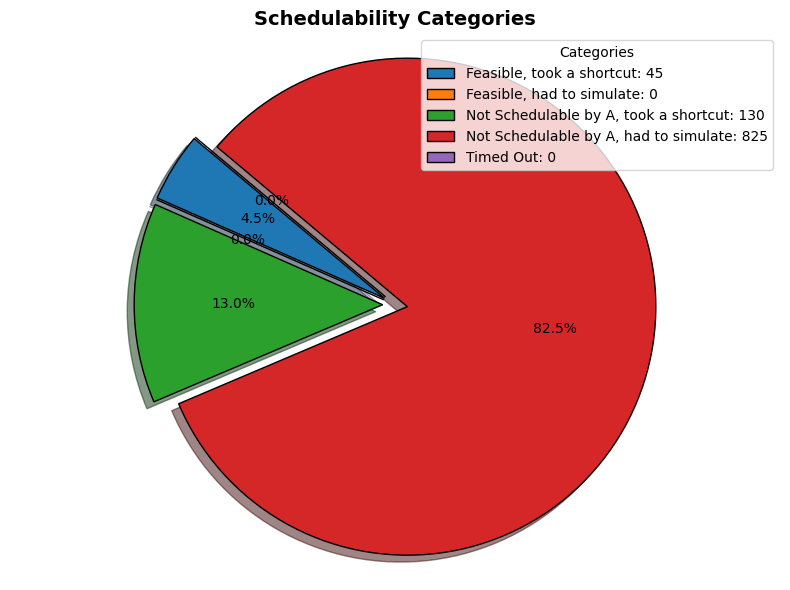

In [15]:
plot_primary_categories(review_task_sets_in_parallel_multi(
    algorithm=MultiprocessorSchedulerType.PARTITIONED_EDF,
    folder_name="tasksets-multiprocessor/",
    num_processors=8,
    heuristic=BestFit(decreasing_utilisation=True, verbose=False)
))

In [ ]:
plot_primary_categories(review_task_sets_in_parallel_multi(
    algorithm=MultiprocessorSchedulerType.GLOBAL_EDF,
    folder_name="tasksets-multiprocessor/",
    num_processors=8,
    verbose=True
))

KeyboardInterrupt: 